# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime

from scipy import signal as fp1
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
npzfile = np.load('../conjuntos_datos_nuevos_2020/19_12_2019_sin_filtrar.npz')
npzfile.files
conjunto_datos_entradasA=npzfile['arr_0']
conjunto_datos_entradasB=npzfile['arr_1']
conjunto_datos_salidas=npzfile['arr_2']
conjunto_datos_eventos=npzfile['arr_3']

## Vamos a rotar todas las imagenes

In [4]:
muestras=conjunto_datos_entradasB.shape[0]
for j in range (1,muestras):
    conjunto_datos_entradasB[j]=np.roll(conjunto_datos_entradasB[j], 45, axis=1)
    conjunto_datos_entradasA[j]=np.roll(conjunto_datos_entradasA[j], 45, axis=1)
    if conjunto_datos_salidas[j,1]<0:
        conjunto_datos_salidas[j,1]=conjunto_datos_salidas[j,1]*180/np.pi+360
    else:
        conjunto_datos_salidas[j,1]=conjunto_datos_salidas[j,1]*180/np.pi

In [5]:

print (muestras)

68002


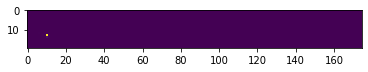

[484749.] 194.0469860441459 18.177219146838418 25.96149444580078


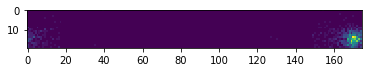

[382135.] 168.91656524845968 347.5838510149014 40.096553802490234


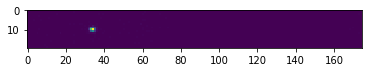

[40642.] 188.06884156760583 66.82773404627174 3.9168307781219482


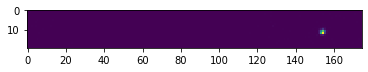

[323278.] 186.5101972923453 314.3885094928187 9.859853744506836


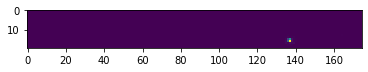

[484749.] 184.41360044489727 279.14918862984325 43.115333557128906


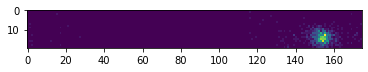

[342632.] 172.25655897145828 313.90336843826884 33.7777099609375


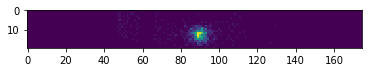

[484749.] 173.81661983912394 181.9618411808077 22.577245712280273


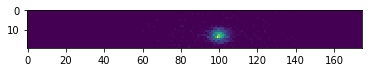

[484749.] 177.0074353770739 200.0544586644474 25.17339515686035


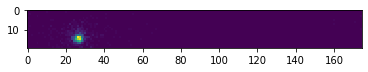

[323806.] 166.34259076783377 53.48559361742813 14.595929145812988


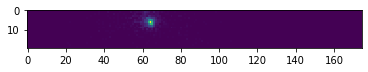

[484749.] 166.7017500814107 126.34514638938134 -30.665485382080078


In [6]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos[idea], conjunto_datos_salidas[idea,0],conjunto_datos_salidas[idea,1],conjunto_datos_salidas[idea,2])

## filtro cosas raras por phi

In [7]:
prueba=conjunto_datos_salidas[:,1].reshape(muestras,1)
print(prueba.shape)
veamos4=np.zeros([muestras,175])
indice4=np.zeros([muestras,1])
for i in range(1,muestras):
    veamos4[i]=np.sum(conjunto_datos_entradasB[i], axis=0)
    intermedio4=np.argmax(veamos4[i], axis=0)
    indice4[i]=intermedio4*2.0571428571428



veamos_bad2=np.where(np.logical_and(np.abs(prueba-indice4)>4,np.abs(prueba-indice4)<356 ).all(axis=1) ) 
conjunto_datos_entradasA_filt_bad2=conjunto_datos_entradasA[veamos_bad2]
conjunto_datos_entradasB_filt_bad2=conjunto_datos_entradasB[veamos_bad2]
conjunto_datos_salidas_filt_bad2=conjunto_datos_salidas[veamos_bad2]
conjunto_datos_eventos_filt_bad2=conjunto_datos_eventos[veamos_bad2]
print(conjunto_datos_entradasB_filt_bad2.shape[0])


veamos_good=np.where(np.logical_not(np.logical_and(np.abs(prueba-indice4)>4,np.abs(prueba-indice4)<356 )).all(axis=1) ) 
conjunto_datos_entradasA_filt_good=conjunto_datos_entradasA[veamos_good]
conjunto_datos_entradasB_filt_good=conjunto_datos_entradasB[veamos_good]
conjunto_datos_salidas_filt_good=conjunto_datos_salidas[veamos_good]
conjunto_datos_eventos_filt_good=conjunto_datos_eventos[veamos_good]
print(conjunto_datos_entradasB_filt_good.shape[0])

(68002, 1)
13371
54631


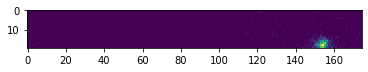

[461127.] 173.739002806414 310.7247668398947 65.5935287475586


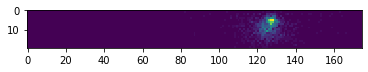

[160879.] 165.3782272245739 254.24675159654976 3.2672224044799805


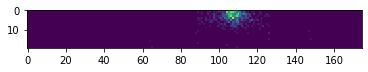

[284490.] 166.78570122010058 218.4664001308925 -56.243812561035156


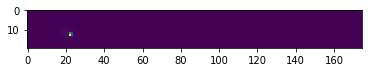

[321274.] 173.5983185801263 38.60489202346531 16.585472106933594


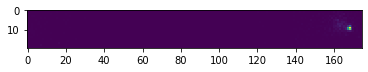

[324073.] 169.56261881367664 332.1773787383508 -14.472124099731445


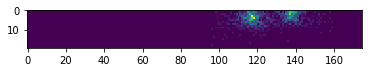

[321616.] 169.54594960604933 281.110182555024 -54.24462127685547


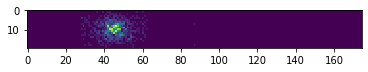

[123781.] 165.24532841268058 90.1227252403347 2.8916220664978027


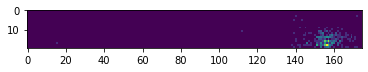

[484749.] 165.63934359602425 317.6662917373637 52.76579666137695


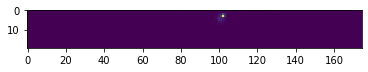

[484749.] 182.67395359713143 204.018885890963 -36.177459716796875


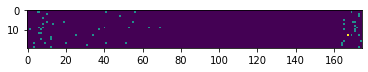

[484749.] 191.95544795588265 321.52635707080213 54.07437515258789


In [8]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt_bad2.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt_bad2[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos_filt_bad2[idea], conjunto_datos_salidas_filt_bad2[idea,0],conjunto_datos_salidas_filt_bad2[idea,1],conjunto_datos_salidas_filt_bad2[idea,2])

In [9]:
np.savez('../conjuntos_datos_nuevos_2020/26_12_2019_filt1',conjunto_datos_entradasA_filt_good, conjunto_datos_entradasB_filt_good, conjunto_datos_salidas_filt_good, conjunto_datos_eventos_filt_good )

## filtro comptom

In [10]:
muestras=conjunto_datos_entradasB_filt_good.shape[0]
conjunto_datos_entradasB_filt_good_rot=np.zeros([muestras,20,175])
for j in range (1,muestras):
    conjunto_datos_entradasB_filt_good_rot[j]=np.roll(conjunto_datos_entradasB_filt_good[j], 10, axis=1)

veamos3_previo=np.zeros([20,175])
veamos3=np.zeros([175])

indices=np.zeros([muestras,1])
for j in range (1,muestras):
    veamos3=np.sum(conjunto_datos_entradasB_filt_good[j], axis=0)
    veamos_peaks = fp1.find_peaks(veamos3, height=40, distance=5)[0]
    indices[j]=veamos_peaks.shape[0]
    veamos3=np.sum(conjunto_datos_entradasB_filt_good_rot[j], axis=0)
    veamos_peaks = fp1.find_peaks(veamos3, height=40, distance=5)[0]
    indices[j]=indices[j]+ veamos_peaks.shape[0]


In [11]:
veamos=np.where((indices>3).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_bad3=conjunto_datos_entradasA_filt_good[veamos]

conjunto_datos_entradasB_filt_bad3=conjunto_datos_entradasB_filt_good[veamos]

conjunto_datos_salidas_filt_bad3=conjunto_datos_salidas_filt_good[veamos]
conjunto_datos_eventos_filt_bad3=conjunto_datos_eventos_filt_good[veamos]

In [12]:
print(conjunto_datos_salidas_filt_bad3.shape[0])

2617


In [13]:
veamos=np.where(np.logical_not(indices>3).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_good3=conjunto_datos_entradasA_filt_good[veamos]

conjunto_datos_entradasB_filt_good3=conjunto_datos_entradasB_filt_good[veamos]

conjunto_datos_salidas_filt_good3=conjunto_datos_salidas_filt_good[veamos]
conjunto_datos_eventos_filt_good3=conjunto_datos_eventos_filt_good[veamos]
print(conjunto_datos_salidas_filt_good3.shape[0])

52014


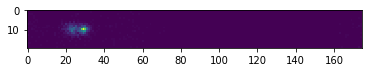

[2395.] 182.90503459563786 57.570945645147006 3.861359119415283


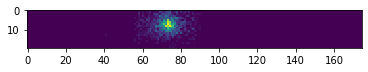

[484749.] 165.09156995916175 147.4289471932096 -14.203923225402832


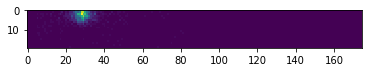

[484749.] 173.00791978729595 55.792189386787065 -51.91888427734375


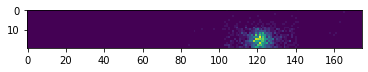

[484749.] 166.45553280408802 247.51196313089395 43.14468765258789


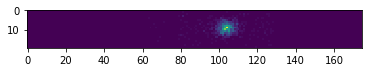

[120485.] 173.74316622342826 210.36205629500478 -1.2857294082641602


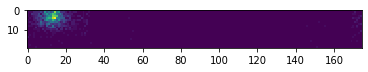

[484749.] 166.11919713021905 23.6838409454307 -42.700809478759766


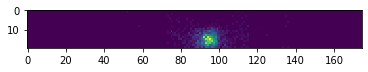

[80851.] 169.41403629655275 191.50450129918164 41.964744567871094


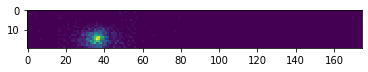

[481966.] 167.69934911423687 71.64783613443298 39.53090286254883


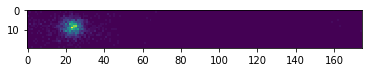

[261339.] 173.18869288770748 46.418663241910735 -6.153883934020996


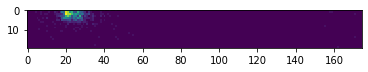

[224366.] 180.31224448809928 40.54548366442834 -52.725502014160156


In [14]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt_bad3.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt_bad3[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos_filt_bad3[idea], conjunto_datos_salidas_filt_bad3[idea,0],conjunto_datos_salidas_filt_bad3[idea,1],conjunto_datos_salidas_filt_bad3[idea,2])

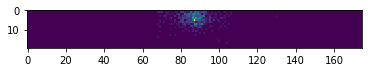

[484749.] 166.68337281115421 176.85279018237307 -42.32467269897461


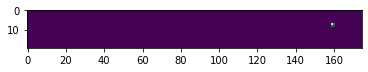

[484749.] 191.29011325110218 325.2334977553374 -15.437204360961914


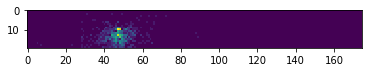

[462934.] 167.35464742662992 94.4696190177229 31.29754066467285


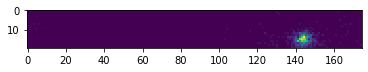

[484749.] 176.77466295027006 293.0958523331499 39.74525833129883


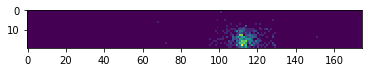

[484749.] 165.71598541281256 229.74476613297568 47.269447326660156


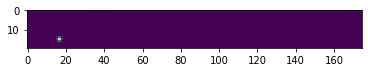

[484749.] 188.2304075861206 31.115523129074916 38.429012298583984


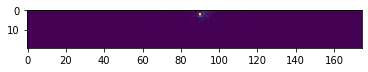

[484749.] 177.02935260402518 186.4951398738008 -56.825904846191406


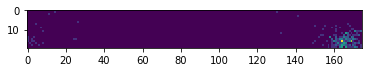

[284220.] 165.26501436198478 339.04286014987724 49.45357131958008


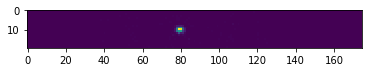

[484749.] 186.37623993713754 160.90632548773976 4.54880952835083


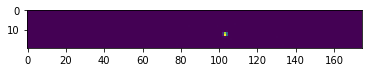

[484749.] 190.35268575290982 209.715271877802 21.182941436767578


In [15]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt_good3.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt_good3[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos_filt_good3[idea], conjunto_datos_salidas_filt_good3[idea,0],conjunto_datos_salidas_filt_good3[idea,1],conjunto_datos_salidas_filt_good3[idea,2])

In [16]:
    
np.savez('../conjuntos_datos_nuevos_2020/26_12_2019_comptom_filt2',conjunto_datos_entradasA_filt_good3, conjunto_datos_entradasB_filt_good3, conjunto_datos_salidas_filt_good3, conjunto_datos_eventos_filt_good3)

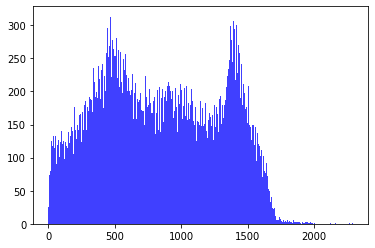

In [17]:
img_rows_t=20
img_cols_t=175
energia1B=conjunto_datos_entradasB_filt_good3.reshape(conjunto_datos_entradasB_filt_good3.shape[0], img_rows_t*img_cols_t)


energia2B=np.sum(energia1B, axis=1)

n1, bins1, patches1=plt.hist(energia2B,400, density=0, facecolor='blue', alpha=0.75)

In [18]:
energia2B_b=energia2B.reshape(energia2B.shape[0],1)


In [19]:
veamos=np.where(np.logical_not(energia2B_b>1250,energia2B_b<1750 ).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_good4=conjunto_datos_entradasA_filt_good3[veamos]

conjunto_datos_entradasB_filt_good4=conjunto_datos_entradasB_filt_good3[veamos]

conjunto_datos_eventos_filt_good4=conjunto_datos_eventos_filt_good3[veamos]
conjunto_datos_salidas_filt_good4=conjunto_datos_salidas_filt_good3[veamos]

In [20]:
    
np.savez('../conjuntos_datos_nuevos_2020/26_12_2019_comptom_filt3',conjunto_datos_entradasA_filt_good4, conjunto_datos_entradasB_filt_good4, conjunto_datos_salidas_filt_good4, conjunto_datos_eventos_filt_good4)

In [22]:
# # import scipy.io as sio
# # import hdf5storage
# # datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
# # conjunto_datos= datos_matlab.get('photodefbox2_todo')
# # conjunto_datos.shape
# npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
# npzfile.files

# # conjunto_datos_entradasA=npzfile['arr_0']
# # conjunto_datos_entradasB=npzfile['arr_1']
# # conjunto_datos_salidas=npzfile['arr_2']
# entradas_sensorsA1=npzfile['arr_0']
# entradas_sensorsB1=npzfile['arr_1']
# coordenadas1=npzfile['arr_2']
# entradas_sensorsA2=npzfile['arr_3']
# entradas_sensorsB2=npzfile['arr_4']
# coordenadas2=npzfile['arr_5']

# conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
# conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
# conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


# print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
# print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
# print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos=conjunto_datos_entradasB_filt_good4.transpose((0,2,1)).reshape(conjunto_datos_entradasB_filt_good4.shape[0], conjunto_datos_entradasB_filt_good4.shape[1]*conjunto_datos_entradasB_filt_good4.shape[2])

In [23]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=10
val_size=80
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test

datos_trA=np.zeros((X_train.shape[0]*L1A,input_output_dim_A))
for i in range(x_train.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_train[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    datos_trA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_trainA = datos_trA;

datos_testA=np.zeros((X_test.shape[0]*L1A,input_output_dim_A))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_testA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_testA = datos_testA;





print(x_trainA.shape)
print(x_testA.shape)


datos_trB=np.zeros((X_train.shape[0]*L1B,input_output_dim_B))
for i in range(x_train.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_train[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_trB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_trainB = datos_trB;

datos_testB=np.zeros((X_test.shape[0]*L1B,input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_test[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_testB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_testB = datos_testB;





print(x_trainB.shape)
print(x_testB.shape)


39012
conjunto_datos shape: (39012, 3500)
3901
31209
3902
(19505, 600)
(19510, 600)
(3901, 500)
(3902, 500)


## Network parameters:

In [24]:
use_regularizer = True
my_regularizer = None
my_epochs = 150
hidden_size=320
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dimA = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgA = Input(shape=(img_rows*img_colsA,))

# "encoded" is the encoded representation of the input
encodedA = Dense(encoding_dimA, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgA)
# "decoded" is the lossy reconstruction of the input
decodedA = Dense(img_colsA*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedA)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderA = Model(input_imgA, decodedA)

encoding_dimB = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgB = Input(shape=(img_rows*img_colsB,))

# "encoded" is the encoded representation of the input
encodedB = Dense(encoding_dimB, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgB)
# "decoded" is the lossy reconstruction of the input
decodedB = Dense(img_colsB*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedB)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderB = Model(input_imgB, decodedB)

Instructions for updating:
Colocations handled automatically by placer.


## Prepare data into training and test set.

In [25]:
x_trainA = x_trainA.reshape(x_trainA.shape[0], img_colsA,img_rows,1)
# X_val = X_val.reshape(X_val.shape[0],img_rows, img_colsA,1)
x_testA = x_testA.reshape(x_testA.shape[0], img_colsA,img_rows,1)


input_shapeA = (img_colsA,img_rows,1)
#input_shape=input_shape.astype('int32')

In [26]:
x_trainA = x_trainA.astype('float32')
# X_val= X_val.astype('float32')
x_testA = x_testA.astype('float32')

print('X_train shape:', x_trainA.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainA
X_test=x_testA

X_train shape: (19505, 30, 20, 1)


Display 20 random training images using image

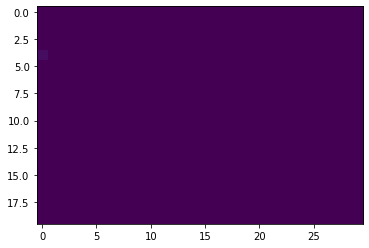

7327


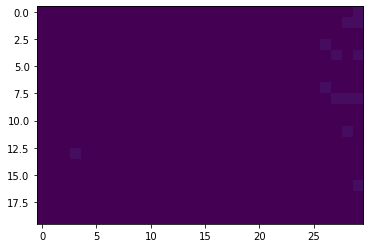

10130


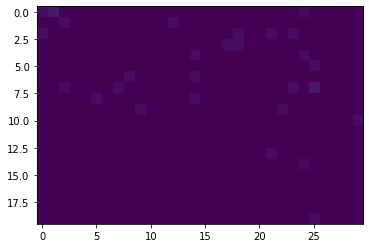

16068


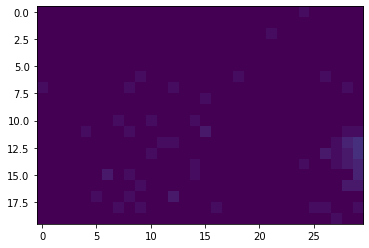

7680


In [27]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsA]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [28]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(19505, 600)
(19510, 600)


In [29]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
# print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[20413])
# print(x_train_scaled[20413])
# print(x_test[20413])
# print(x_test_scaled[20413])

## Build the autoencoder. 

Create our metrics, for example energy

In [30]:
import keras.backend as KK
import keras.callbacks as KKcall

In [31]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [32]:
# this model maps an input to its encoded representation
encoderA = Model(input_imgA, encodedA)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputA = Input(shape=(encoding_dimA,))
# retrieve the last layer of the autoencoder model
decoder_layerA = autoencoderA.layers[-1]
# create the decoder model
decoderA = Model(encoded_inputA, decoder_layerA(encoded_inputA))

autoencoderA.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderA.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [33]:
algoritmo='RMSprop'
experimento="scaledA_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}{}".format(encoding_dimA,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderA.fit(x_train_scaled, x_train_scaled,
                epochs=200,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Instructions for updating:
Use tf.cast instead.
Train on 19505 samples, validate on 19510 samples
Epoch 1/200
19505/19505 [==============================] - 1s 51us/step - loss: 9.3310 - energy_error: -37.2001 - val_loss: 9.7995 - val_energy_error: -25.6570
Epoch 2/200
19505/19505 [==============================] - 0s 25us/step - loss: 9.1684 - energy_error: -20.5059 - val_loss: 9.6730 - val_energy_error: -26.2560
Epoch 3/200
19505/19505 [==============================] - 0s 23us/step - loss: 9.0439 - energy_error: -21.9587 - val_loss: 9.5601 - val_energy_error: -28.5419
Epoch 4/200
19505/19505 [==============================] - 0s 23us/step - loss: 8.9345 - energy_error: -23.4748 - val_loss: 9.4614 - val_energy_error: -30.1771
Epoch 5/200
19505/19505 [==============================] - 0s 23us/step - loss: 8.8392 - energy_error: -23.9889 - val_loss: 9.3753 - val_energy_error: -31.1009
Epoch 6/200
19505/19505 [==============================] - 0s 24us/step - loss: 8.7557 - energy_error:

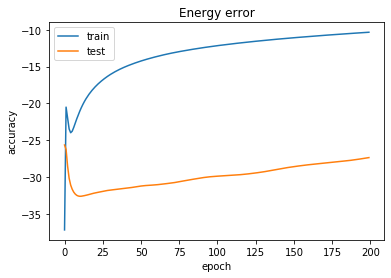

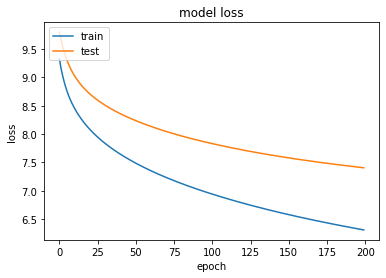

In [34]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# import pandas as pd 
# autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [36]:
autoencoderA.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimA,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [37]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [38]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoderA.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled)
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


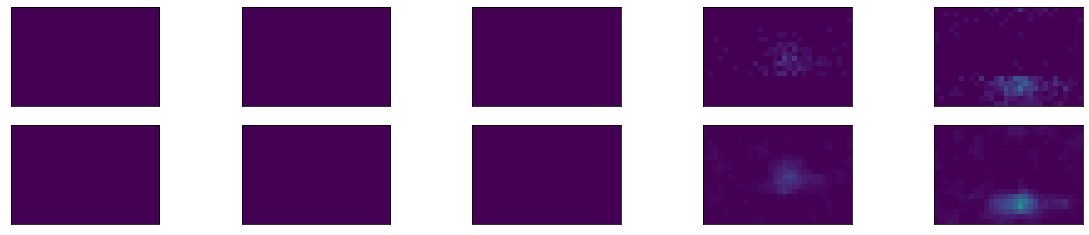

12470


In [39]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsA,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


In [40]:
x_trainB = x_trainB.reshape(x_trainB.shape[0], img_colsB, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testB = x_testB.reshape(x_testB.shape[0], img_colsB, img_rows,1)


input_shapeB = (img_colsB, img_rows,1)
#input_shape=input_shape.astype('int32')

In [41]:
x_trainB = x_trainB.astype('float32')
# X_val= X_val.astype('float32')
x_testB = x_testB.astype('float32')

print('X_train shape:', x_trainB.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainB
X_test=x_testB

X_train shape: (3901, 25, 20, 1)


Display 20 random training images using image

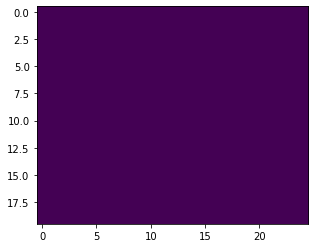

1438


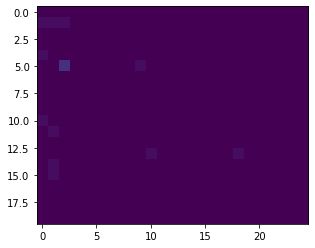

3488


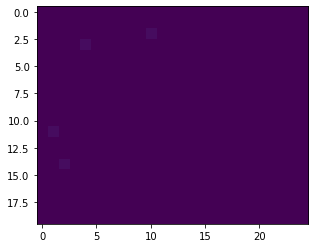

2263


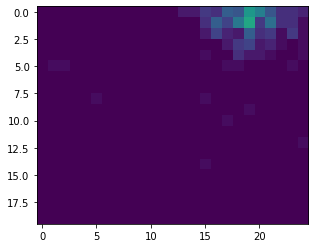

462


In [42]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsB]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [43]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(3901, 500)
(3902, 500)


In [44]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
# print(min_max_scaler)
# x_train_scaled = min_max_scaler.transform(x_train)
# x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[2413])
# print(x_train_scaled[2413])
# print(x_test[2413])
# print(x_test_scaled[2413])

## Build the autoencoder. 

Create our metrics, for example energy

In [45]:
import keras.backend as KK
import keras.callbacks as KKcall

In [46]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [47]:
# this model maps an input to its encoded representation
encoderB = Model(input_imgB, encodedB)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputB = Input(shape=(encoding_dimB,))
# retrieve the last layer of the autoencoder model
decoder_layerB = autoencoderB.layers[-1]
# create the decoder model
decoder = Model(encoded_inputB, decoder_layerB(encoded_inputB))

autoencoderB.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderB.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [48]:
algoritmo='RMSprop'
experimento="scaledB_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}{}".format(encoding_dimB,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderB.fit(x_train_scaled, x_train_scaled,
                epochs=500,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 3901 samples, validate on 3902 samples
Epoch 1/500
3901/3901 [==============================] - 0s 54us/step - loss: 11.2460 - energy_error: -58.8431 - val_loss: 9.8613 - val_energy_error: -37.9494
Epoch 2/500
3901/3901 [==============================] - 0s 28us/step - loss: 11.1455 - energy_error: -35.7769 - val_loss: 9.8046 - val_energy_error: -24.0137
Epoch 3/500
3901/3901 [==============================] - 0s 29us/step - loss: 11.0951 - energy_error: -25.7261 - val_loss: 9.7665 - val_energy_error: -17.6818
Epoch 4/500
3901/3901 [==============================] - 0s 27us/step - loss: 11.0557 - energy_error: -21.4824 - val_loss: 9.7340 - val_energy_error: -15.4390
Epoch 5/500
3901/3901 [==============================] - 0s 25us/step - loss: 11.0196 - energy_error: -20.0212 - val_loss: 9.7031 - val_energy_error: -14.7037
Epoch 6/500
3901/3901 [==============================] - 0s 26us/step - loss: 10.9847 - energy_error: -19.4204 - val_loss: 9.6731 - val_energy_error: -14.389

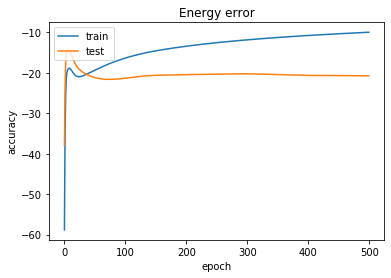

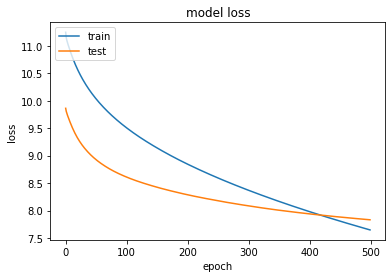

In [49]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# import pandas as pd 
# autoencoderB.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [51]:
autoencoderB.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimB,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [52]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [53]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
# decoded_imgs_scaled = autoencoderB.predict(x_test_min_max)
decoded_imgs_scaledB = autoencoderB.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaledB)
# decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


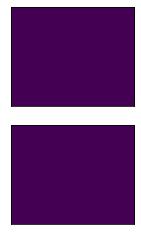

In [54]:
n = 1  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsB,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [55]:
x_total=conjunto_datos[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,0: L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,L1A*input_output_dim_A+k*input_output_dim_B:L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    

In [56]:
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse_idea=np.reshape(mse,(mse.shape[0],1))

In [57]:
veamos=np.where((mse_idea<3).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_good5=conjunto_datos_entradasA_filt_good4[veamos]

conjunto_datos_entradasB_filt_good5=conjunto_datos_entradasB_filt_good4[veamos]

conjunto_datos_salidas_filt_good5=conjunto_datos_salidas_filt_good4[veamos]

conjunto_datos_eventos_filt_good5=conjunto_datos_eventos_filt_good4[veamos]

Salvamos los reusltados

In [66]:
print(conjunto_datos_entradasA.shape)
print(conjunto_datos_entradasA_filt_good.shape)
print(conjunto_datos_entradasA_filt_good3.shape)
print(conjunto_datos_entradasA_filt_good4.shape)   
print(conjunto_datos_entradasA_filt_good5.shape)    
print(conjunto_datos_entradasB_filt_good5.shape)    
print(conjunto_datos_eventos_filt_good5.shape)   
print(conjunto_datos_salidas_filt_good5.shape)   

(68002, 20, 175)
(54631, 20, 175)
(52014, 20, 175)
(39012, 20, 175)
(29714, 20, 175)
(29714, 20, 175)
(29714, 1)
(29714, 3)


In [60]:
np.savez('../conjuntos_datos_nuevos_2020/26_12_2019_filt4',conjunto_datos_entradasA_filt_good5, conjunto_datos_entradasB_filt_good5, conjunto_datos_salidas_filt_good5, conjunto_datos_eventos_filt_good5 )

## Visualizamos los resultados

Visualizamos todos los sensores: 

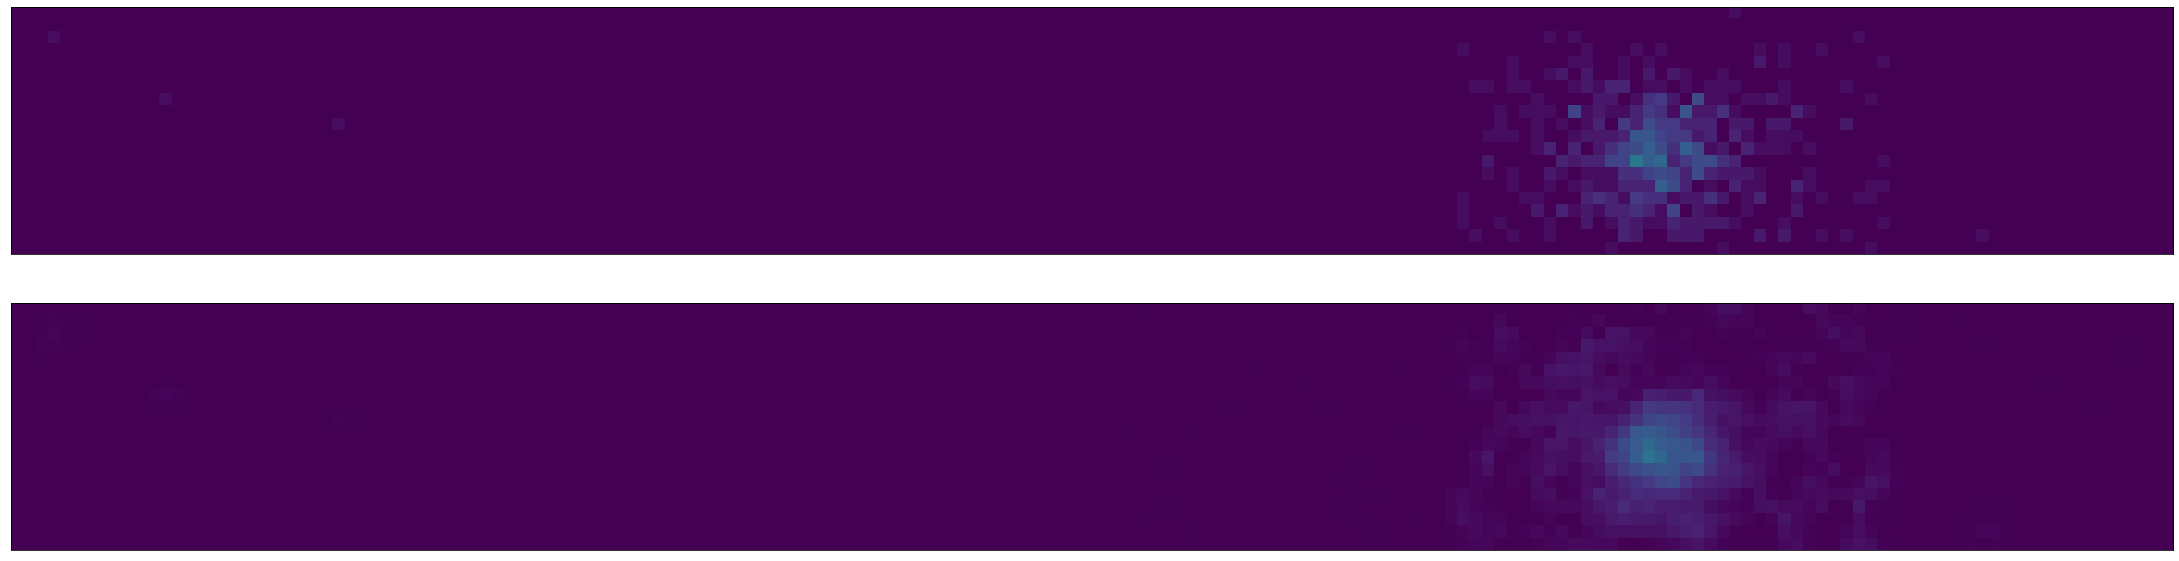

In [64]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,cara_externa.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()